In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/Google Colab Notebooks/Mini Sem 8/dataset/large sample/IBM_2years_60Min.csv')

In [ ]:
print(raw_data.shape)
raw_data.head()

(6707, 7)


,Unnamed: 0,time,open,high,low,close,volume
0,0,2020-04-27 05:00:00,108.325771,108.325771,108.325771,108.325771,344
1,1,2020-04-27 08:00:00,108.153113,108.714252,108.153113,108.714252,2625
2,2,2020-04-27 09:00:00,108.774682,109.525746,108.774682,109.033670,8240
3,3,2020-04-27 10:00:00,108.774682,109.577543,108.317138,109.180429,760734
4,4,2020-04-27 11:00:00,109.189062,109.504163,108.627923,109.094791,595594


In [ ]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

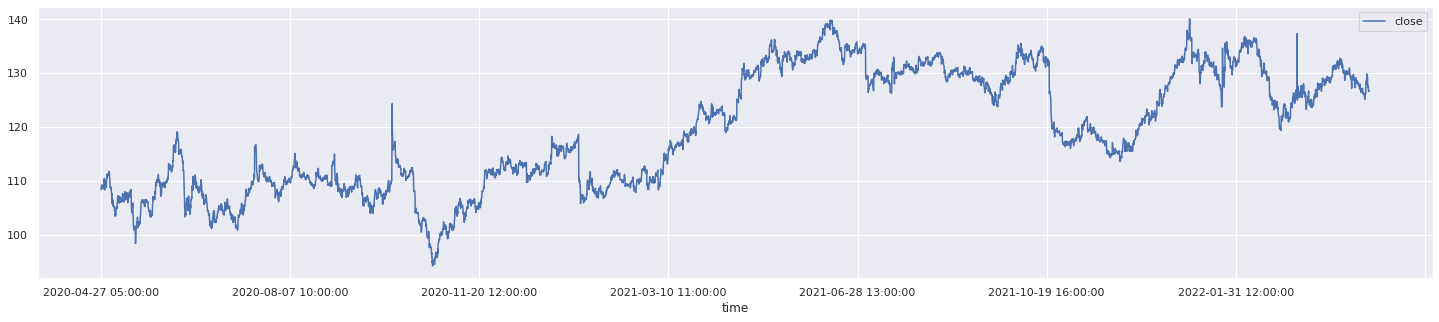

In [ ]:
close_ds.plot(x='time', y='close', figsize=(25, 5))

In [ ]:
# ema and vwap

from time import time
from datetime import datetime

"""
  Parameters
    d - previous number of data points to use for EMA
    price - stock price list
  Returns
    list of EMA of all points starting from the dth data point
"""
def calculate_ema(d, price) :
  print(f" Days {d} \n Length of prices {len(price)}")
  # formula https://www.investopedia.com/terms/e/ema.asp
  ema = []                                    # stores the ema starting from the dth data point i.e corresponding to price[d]
  ema_yesterday = sum(price[:d])/d            # sma of first d days, this will serve as the EMA of yesterday
  multiplier = 2/(d+1)                        # multiplier 
  for i in range(d,len(price)):
    ema_today = price[i]*multiplier + ema_yesterday*(1-multiplier)  
    ema.append(ema_today)
    ema_yesterday = ema_today
  print(f" Length of EMA list {len(ema)}")
  return ema



"""
  Parameters
    df - original dataframe
  Returns
    list of vwap
"""

def calculate_vwap(df):
  
  time_format = "%Y-%m-%d %H:%M:%S"
  
  sum_pv = 0
  sum_volume = 0
  
  vwap = []
  
  previous_day = datetime.strptime(df["time"][0], time_format).day

  for i in range(len(df)):
    
    current_day = datetime.strptime(df["time"][i], time_format).day

    if(current_day!=previous_day):
      sum_pv = 0
      sum_volume = 0

    previous_day = current_day

    sum_pv += ((df["high"][i] + df["low"][i] + df["close"][i])/3) * df["volume"][i]
    sum_volume += df["volume"][i]
    vwap.append(sum_pv/sum_volume)
  return vwap

In [ ]:
# price list
price = list(close_ds.drop('time', axis=1).values)
print(f"len prices = {len(price)}")

# ema taking 10 previous points for calculation
ema = calculate_ema(10,price)
print(f"len ema = {len(ema)}")

vwap = calculate_vwap(raw_data)
print(f"len vwap = {len(vwap)}")

len prices = 6707
 Days 10 
 Length of prices 6707
 Length of EMA list 6697
len ema = 6697
len vwap = 6707


In [ ]:
# make all ema, vwap, prices lists of equal length 
price = price[-len(ema):]
vwap = vwap[-len(ema):]

No handles with labels found to put in legend.


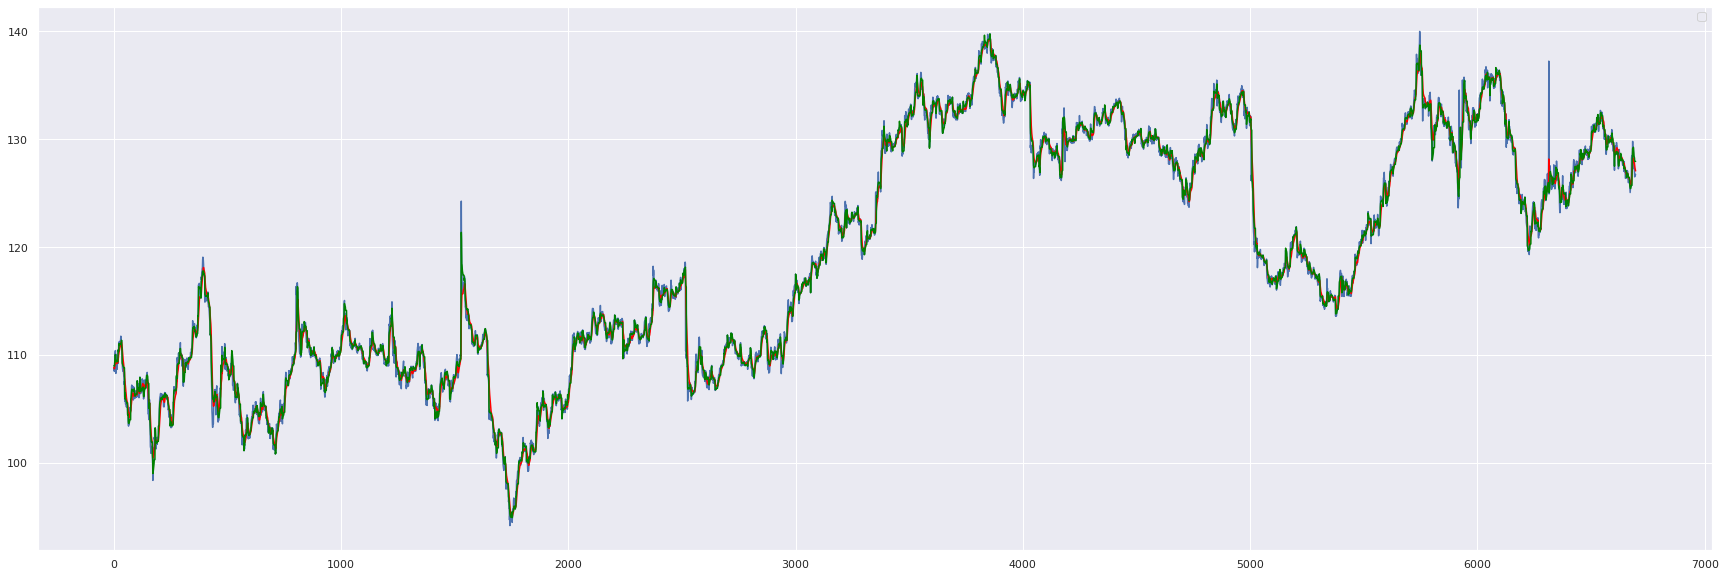

In [ ]:
plt.figure(figsize=(30,10))

plt.plot(price)
plt.plot(ema, color='red')
plt.plot(vwap,color='green')
plt.legend()
plt.show()

In [ ]:

# split a multivariate sequence into samples
# n_steps ---> number of lag observations

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:

ema = np.array(ema).reshape(len(ema), 1)
vwap = np.array(vwap).reshape(len(vwap), 1)
price = np.array(price).reshape(len(price), 1)
dataset = np.hstack((ema, vwap, price))
print(dataset)

[[108.8445086  108.98114654 108.61065716]
 [108.83181294 108.98111822 108.77468248]
 [108.77433698 108.98087767 108.51569514]
 ...
 [127.2337918  127.9427036  126.66      ]
 [127.14582966 127.94212141 126.75      ]
 [127.06476972 127.94199548 126.7       ]]


In [ ]:
n_steps = 3 
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
print(X[0], y[0])

(6695, 3, 2) (6695,)
[[108.8445086  108.98114654]
 [108.83181294 108.98111822]
 [108.77433698 108.98087767]] 108.515695138


In [ ]:
# train_test_split 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# type(X_train.values)

(4686, 3, 2)
(4686,)
(2009, 3, 2)
(2009,)


In [ ]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

# CNN

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 64)             320       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
cnn_history = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, verbose=2)

Epoch 1/40
147/147 - 1s - loss: 2029.0049 - val_loss: 0.9309 - 1s/epoch - 10ms/step
Epoch 2/40
147/147 - 1s - loss: 0.6674 - val_loss: 0.7383 - 806ms/epoch - 5ms/step
Epoch 3/40
147/147 - 1s - loss: 0.6604 - val_loss: 0.7421 - 623ms/epoch - 4ms/step
Epoch 4/40
147/147 - 1s - loss: 0.6618 - val_loss: 0.7397 - 845ms/epoch - 6ms/step
Epoch 5/40
147/147 - 1s - loss: 0.6612 - val_loss: 0.7394 - 834ms/epoch - 6ms/step
Epoch 6/40
147/147 - 1s - loss: 0.6600 - val_loss: 0.7386 - 704ms/epoch - 5ms/step
Epoch 7/40
147/147 - 1s - loss: 0.6631 - val_loss: 0.7378 - 808ms/epoch - 5ms/step
Epoch 8/40
147/147 - 1s - loss: 0.6603 - val_loss: 0.7432 - 652ms/epoch - 4ms/step
Epoch 9/40
147/147 - 1s - loss: 0.6593 - val_loss: 0.7389 - 814ms/epoch - 6ms/step
Epoch 10/40
147/147 - 1s - loss: 0.6614 - val_loss: 0.7426 - 728ms/epoch - 5ms/step
Epoch 11/40
147/147 - 1s - loss: 0.6597 - val_loss: 0.7420 - 615ms/epoch - 4ms/step
Epoch 12/40
147/147 - 1s - loss: 0.6597 - val_loss: 0.7374 - 673ms/epoch - 5ms/step


Text(0, 0.5, 'MSE')

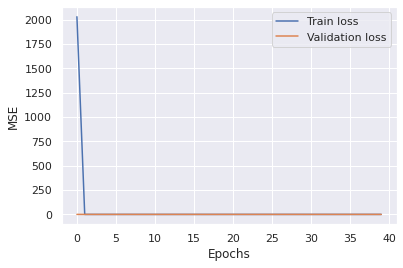

In [ ]:
# plots 
fig = plt.figure()
plt.plot(cnn_history.history['loss'], label='Train loss')
plt.plot(cnn_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [ ]:
# RMSE calculation
from sklearn.metrics import mean_squared_error
cnn_train_pred = model_cnn.predict(X_train)
cnn_test_pred = model_cnn.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, cnn_test_pred)))

Train rmse: 0.8164803360082795
Validation rmse: 0.8666633347379695


In [ ]:
print(y_test[0:10])
print(cnn_test_pred[0:10])

[126.87089947 126.73113276 127.0013484  126.10684147 126.20933706
 126.41432823 126.36773932 126.20933706 126.41432823 126.00434588]
[[127.38664 ]
 [127.35015 ]
 [127.25805 ]
 [127.17491 ]
 [127.02709 ]
 [126.81227 ]
 [126.72967 ]
 [126.67878 ]
 [126.623795]
 [126.58237 ]]


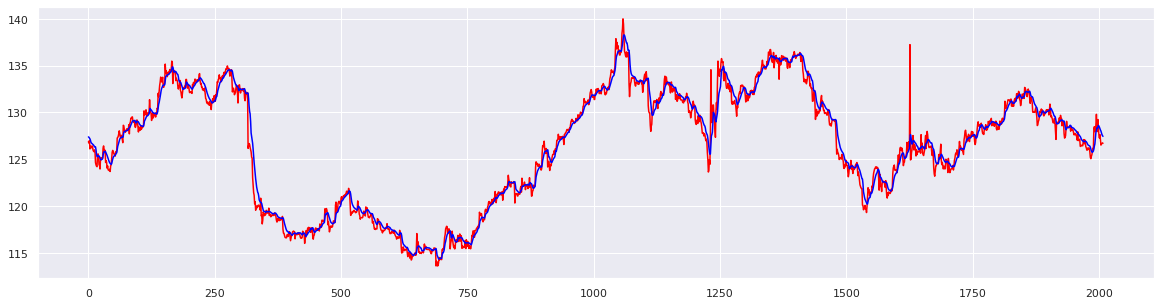

In [ ]:
# pd.Series(y_test[:100]).plot(figsize=(30, 10))
# pd.Series(cnn_test_pred.flatten()[:100]).plot(figure=(30, 10))
plt.figure(figsize=(20, 5))
plt.plot(pd.Series(y_test), color='red')
plt.plot(pd.Series(cnn_test_pred.flatten()), color='blue')